In [ ]:
!pip install opencv-python-headless tensorflow keras matplotlib seaborn imutils

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset


Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -n face-mask-dataset.zip -d data



Archive:  face-mask-dataset.zip


In [ ]:
import os
print("Folders under data/face-mask-dataset:", os.listdir("data/data"))


Folders under data/face-mask-dataset: ['without_mask', 'with_mask']


📁 Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 77% 125M/163M [00:00<00:00, 1.31GB/s]
100% 163M/163M [00:00<00:00, 1.09GB/s]
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7168 - loss: 0.5769 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 830ms/step - accuracy: 0.9778 - loss: 0.1195 - val_accuracy: 0.5000 - val_loss: 0.7132
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 881ms/step - accuracy: 0.9838 - loss: 0.0568 - val_accuracy: 0.5000 - val_loss: 0.7232
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 826ms/step - accuracy: 0.9949 - loss: 0.0258 - val_accuracy: 0.5013 - val_loss: 0.7786
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 810ms/step - accuracy: 0.9916 - loss: 0.0276 - val_accuracy: 0.5075 - val_loss: 0.8174
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 854ms/step - accuracy: 0.9955 - loss: 0.0189 - val_accuracy: 0.5138 - val_loss: 0.9646
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 835ms/step - accuracy: 0.9951 - loss: 0.0180 - val_accuracy: 0.6725 - val_loss: 0.6300
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - accuracy: 0.9991 - loss: 0.0075 - val_accuracy: 0.6125 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 716ms/step
              precision    recall  f1-score   support

   with_mask       0.95      0.99      0.97       400
without_mask       0.99      0.95      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



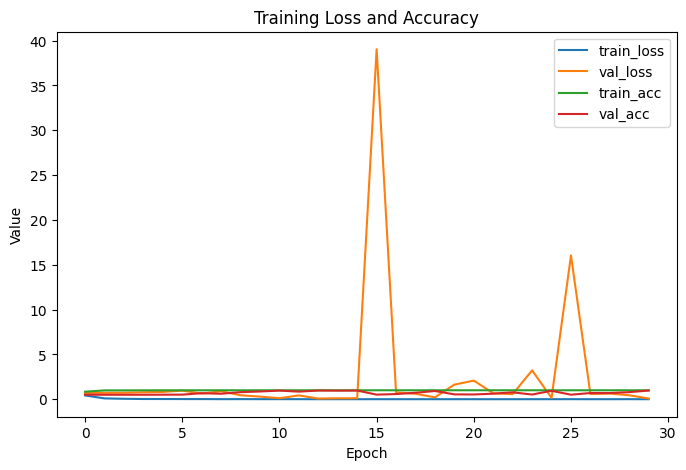

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from re import A
A
# Face Mask Detector Training with EfficientNetB0
# ------------------------------------------------

# Install dependencies


import os
import shutil
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Prepare Kaggle Dataset
# -------------------------------
from google.colab import files

# Upload kaggle.json credentials
print("📁 Upload your kaggle.json file:")
uploaded = files.upload()
uploaded_filename = next(iter(uploaded))
target_path = os.path.expanduser("~/.kaggle/kaggle.json")
os.makedirs(os.path.dirname(target_path), exist_ok=True)
shutil.move(uploaded_filename, target_path)
os.chmod(target_path, 0o600)

# Download and unzip face mask dataset
!kaggle datasets download -d omkargurav/face-mask-dataset
os.system("unzip -q face-mask-dataset.zip -d data")

def load_data(dataset_dir, img_size=224, max_per_class=None):
    data, labels = [], []
    for category in ["with_mask", "without_mask"]:
        folder = os.path.join(dataset_dir, category)  # Correct folder per class
        files = os.listdir(folder)
        if max_per_class:
            files = files[:max_per_class]
        for fname in files:
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            if img is None:
                continue  # skip unreadable files
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(category)
    return np.array(data, dtype="float32"), np.array(labels)
# -------------------------------
# Step 2: Load & Preprocess Data
# -------------------------------
IMG_SIZE = 224
MAX_IMAGES_PER_CLASS = 1000  # adjust if needed
data, labels = load_data("data/data", img_size=224, max_per_class=2000)


data /= 255.0

# One-hot encoding
lb = LabelBinarizer()
y = lb.fit_transform(labels)
y = np.hstack((y, 1 - y))

# Split train/test
(trainX, testX, trainY, testY) = train_test_split(
    data, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# Step 3: Data Augmentation
# -------------------------------
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ----------------------------------
# Step 4: Build Model - EfficientNet
# ----------------------------------
baseModel = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    pooling=None  # we'll add GAP manually
)

# Add custom head
top = baseModel.output
# Global average pooling
top = GlobalAveragePooling2D(name="gap")(top)
# Dropout for regularization
top = Dropout(0.5, name="dropout")(top)
# Final classification layer
head = Dense(2, activation="softmax", name="classifier")(top)

model = Model(inputs=baseModel.input, outputs=head)

# Freeze base layers
for layer in baseModel.layers:
    layer.trainable = True

# Compile
opt = Adam(learning_rate=1e-4)
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

# -------------------------------
# Step 5: Train
# -------------------------------
EPOCHS = 30
BATCH_SIZE = 64

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS
)

# --------------------------------
# Step 6: Evaluate & Save Model
# --------------------------------
# Classification report
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(testY, axis=1)

print(classification_report(trueIdxs, predIdxs, target_names=lb.classes_))

# Plot training curves
plt.figure(figsize=(8, 5))
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

# Save model
model.save("mask_detector_efficientnetb0.h5")

# Optionally download
from google.colab import files as fldl
fldl.download("mask_detector_efficientnetb0.h5")
